 Notebook color scheme 

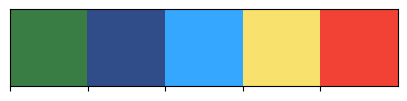

In [1]:
from typing import Any, Dict, Tuple, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision
import torchmetrics
import albumentations
import lightning.pytorch as pl
import os
import sys
import wandb
import json
import gc

from astropy.io import fits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib.colors import ListedColormap
from rich.console import Console
from rich.table import Table
from rich.progress import track
from rich import print as rprint

from collections import defaultdict

MY_COLORS = ["#3A7D44", "#304C89", "#35A7FF", "#f8e16c", "#F24236"]
MY_COLORMAP = ListedColormap(MY_COLORS)

WANDB_CONFIG = {"experiment":"GSoc2023", "_wandb_kernel":"aot"}

torch.set_float32_matmul_precision('medium')

rprint("[bold #35A7FF] Notebook color scheme [/bold #35A7FF]")
sns.palplot(sns.color_palette(MY_COLORS))
plt.show()

In [2]:
api_key = os.environ['WANDB_API_KEY']
!wandb login $api_key

wandb: Appending key for api.wandb.ai to your netrc file: /home/darthvader/.netrc


In [3]:
df = pd.read_csv("../data/lens_finding/SpaceBasedTraining/classifications.csv")

In [4]:
def view_table(data: "pd.DataFrame", n_rows: Optional[int]=5, title: Optional[str]="Title", rule: Optional[bool]=False) -> None:
    """
    This function is used to create a aesthetic view of a dataframe.
    
    :params data: the dataframe
    :params n_rows: number of n rows to view of the dataframe.
    :params title: A title for the aesthetic table.
    :params rule: Whether to add any ruler or not.
    
    :returns: None
    """
    
    table = Table(title=title, caption=f"This data originally has {data.shape[0]} records.")
    data = data.sample(n_rows, random_state=32)
    
    for idx, col in enumerate(data.columns):
        table.add_column(col, justify="left", style=MY_COLORS[idx % len(MY_COLORS)])
        
    for row in data.iterrows():
        row = (str(r) for r in row[1])
        table.add_row(*row)
        
    console = Console()
    
    if rule:
        console.rule(f"[bold #35A7FF]{title}")
    
    console.print(table)

In [5]:
view_table(df, title="Given MetaData")

                                      Given MetaData                                       
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID       ┃ is_lens ┃ Einstein_area ┃ numb_pix_lensed_image ┃ flux_lensed_image_in_sigma ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 100891.0 │ 1.0     │ 3.50228e-12   │ 46.0                  │ 137.648                    │
│ 116431.0 │ 1.0     │ 1.40273e-10   │ 259.0                 │ 905.651                    │
│ 113996.0 │ 1.0     │ 2.33485e-12   │ 137.0                 │ 962.784                    │
│ 116920.0 │ 1.0     │ 7.36775e-12   │ 116.0                 │ 983.103                    │
│ 105940.0 │ 0.0     │ 2.04066e-10   │ 0.0                   │ 0.0                        │
└──────────┴─────────┴───────────────┴───────────────────────┴────────────────────────────┘
                          This data originally has 18000 records.                          

In [6]:
def addImagePaths(data: "pd.DataFrame", img_fp: str) -> "pd.DataFrame":
    """
    This function is used to add the image paths to the current MetaData
    
    :param data: the current metaData
    :param img_fp: the directory where the images are present.
    
    :returns: the metaData with the image paths
    """
    
    img_paths = list()
    
    for ids in track(data["ID"].values):
        img_name = f"imageEUC_VIS-{ids}.fits"
        img_paths.append(os.path.join(img_fp, img_name))
        
    assert all([os.path.exists(path) for path in img_paths]), "Some of the files does not exists"
                
    data["img_path"] = img_paths
    data = data.sample(frac=1, random_state=1234)
    return data

In [7]:
df = addImagePaths(df, "../data/lens_finding/SpaceBasedTraining/files")
view_table(df, title="Modified MetaData")

Output()

                                                 Modified MetaData                                                 
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area ┃ numb_pix_lensed_image ┃ flux_lensed_image_in_si… ┃ img_path                  ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 104049 │ 1       │ 6.69324e-12   │ 327                   │ 2051.01                  │ ../data/lens_finding/Spa… │
│ 111601 │ 1       │ 2.05986e-11   │ 132                   │ 620.031                  │ ../data/lens_finding/Spa… │
│ 106414 │ 1       │ 8.80836e-10   │ 511                   │ 1858.27                  │ ../data/lens_finding/Spa… │
│ 102563 │ 1       │ 3.53756e-10   │ 599                   │ 1796.08                  │ ../data/lens_finding/Spa… │
│ 101056 │ 1       │ 2.87161e-10   │ 53                    │ 203.097                  │ ../data/lens_finding/Spa… │
└────────┴─────────┴───────────────┴───────────────────────┴──────────────────────────┴───────────────────────────┘
                                      This data originally has 18000 records.                                      

# Create DataLoaders

In [8]:
class LensFindingDataset(td.Dataset):
    def __init__(self, data: "pd.Dataframe", resize: Optional[Tuple]=None, is_train: Optional[bool]=True):
        
        self.data = data
        self.resize = resize if resize is not None else (224, 224)
        self.is_train = is_train
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        row = self.data.iloc[idx]
        
        img_path = row["img_path"]
        label = row["is_lens"]
        
        img = fits.getdata(img_path)
        img = np.expand_dims(img, axis=-1)
        img = np.concatenate([img, img, img], axis=-1)
        
        other_features = np.array([row["Einstein_area"], row["numb_pix_lensed_image"], row["flux_lensed_image_in_sigma"]])
        
        transformations = None
        if self.is_train:
            transformations = albumentations.Compose([
                albumentations.RandomBrightnessContrast(),
                albumentations.Rotate(),
                albumentations.GaussianBlur(),
                albumentations.GaussNoise(),
                albumentations.ShiftScaleRotate(),
                albumentations.GridDistortion(),
                albumentations.OpticalDistortion(),
                albumentations.HueSaturationValue(),
                albumentations.Resize(self.resize[0], self.resize[1], always_apply=True),
                albumentations.CenterCrop(self.resize[0], self.resize[1], always_apply=True)
            ])
            
        else:
            transformations = albumentations.Compose([
                albumentations.Resize(self.resize[0], self.resize[1], always_apply=True),
                albumentations.CenterCrop(self.resize[0], self.resize[1], always_apply=True)
            ])
            
        
        aug = transformations(image = img)
        img = aug["image"]
        
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        
        return {
            "img" : torch.tensor(img, dtype=torch.float),
            "label" : torch.tensor(label, dtype=torch.float),
            "other_feats" : torch.tensor(other_features, dtype=torch.float)
        }
        

In [9]:
class LitLensFindingDataLoader(pl.LightningDataModule):
    def __init__(self, data: "pd.DataFrame", resize: Optional[Tuple]=None, batch_sz: Optional[int]=64):
        
        self.data = data
        self.resize = resize
        self.batch_sz = batch_sz
        
        self.dataset = None
        
    def setup(self, stage:Optional[str] = None):
        
        if stage not in ["train", "val", "test"]:
            raise Exception(f"Expected value of stage to be either train/val/test. Found {stage}")
            
        if stage == "train":
            self.dataset = LensFindingDataset(self.data, resize=self.resize, is_train=True)
            
        else:
            self.dataset = LensFindingDataset(self.data, resize=self.resize, is_train=False)
            
    def train_dataloader(self):
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=True, num_workers=4, pin_memory=True)
    
    def val_dataloader(self):
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=False, num_workers=4, pin_memory=True)
    
    def test_dataloader(self):
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
df_train, df_test = train_test_split(df, test_size=.1, random_state=32, shuffle=True, stratify=df["is_lens"])
df_val, df_test = train_test_split(df_test, test_size=.5, random_state=32, stratify=df_test['is_lens'])


view_table(df_train, title="Training Data", rule=True)
view_table(df_val, title="Validation Data", rule=True)
view_table(df_test, title="Test Data", rule=True)

────────────────────────────────────────────────── Training Data ──────────────────────────────────────────────────

                                                   Training Data                                                   
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area ┃ numb_pix_lensed_image ┃ flux_lensed_image_in_si… ┃ img_path                  ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 102942 │ 1       │ 1.55527e-10   │ 638                   │ 1687.67                  │ ../data/lens_finding/Spa… │
│ 108528 │ 1       │ 2.23886e-11   │ 30                    │ 86.6408                  │ ../data/lens_finding/Spa… │
│ 101163 │ 1       │ 1.64322e-10   │ 527                   │ 880.99                   │ ../data/lens_finding/Spa… │
│ 111399 │ 1       │ 5.52582e-12   │ 314                   │ 1354.33                  │ ../data/lens_finding/Spa… │
│ 110615 │ 1       │ 1.83426e-09   │ 146                   │ 28233.6                  │ ../data/lens_finding/Spa… │
└────────┴─────────┴───────────────┴───────────────────────┴──────────────────────────┴───────────────────────────┘
                                      This data originally has 16200 records.                                      

───────────────────────────────────────────────── Validation Data ─────────────────────────────────────────────────

                                                  Validation Data                                                  
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area ┃ numb_pix_lensed_image ┃ flux_lensed_image_in_si… ┃ img_path                  ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 100991 │ 0       │ 1.85525e-09   │ 0                     │ 0.0                      │ ../data/lens_finding/Spa… │
│ 104325 │ 1       │ 7.28941e-10   │ 920                   │ 1777.84                  │ ../data/lens_finding/Spa… │
│ 107192 │ 1       │ 5.26639e-12   │ 62                    │ 633.679                  │ ../data/lens_finding/Spa… │
│ 117984 │ 1       │ 2.54239e-12   │ 72                    │ 126.21                   │ ../data/lens_finding/Spa… │
│ 105907 │ 1       │ 8.60393e-10   │ 970                   │ 2877.71                  │ ../data/lens_finding/Spa… │
└────────┴─────────┴───────────────┴───────────────────────┴──────────────────────────┴───────────────────────────┘
                                       This data originally has 900 records.                                       

──────────────────────────────────────────────────── Test Data ────────────────────────────────────────────────────

                                                     Test Data                                                     
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area ┃ numb_pix_lensed_image ┃ flux_lensed_image_in_si… ┃ img_path                  ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 104828 │ 1       │ 5.11073e-12   │ 135                   │ 760.195                  │ ../data/lens_finding/Spa… │
│ 107611 │ 1       │ 2.69805e-12   │ 98                    │ 291.418                  │ ../data/lens_finding/Spa… │
│ 111913 │ 1       │ 1.816e-12     │ 202                   │ 1308.34                  │ ../data/lens_finding/Spa… │
│ 115437 │ 1       │ 1.48725e-09   │ 1527                  │ 7123.97                  │ ../data/lens_finding/Spa… │
│ 101047 │ 1       │ 1.77965e-09   │ 6699                  │ 63682.5                  │ ../data/lens_finding/Spa… │
└────────┴─────────┴───────────────┴───────────────────────┴──────────────────────────┴───────────────────────────┘
                                       This data originally has 900 records.                                       

In [11]:
scaler = MinMaxScaler()
df_train[['Einstein_area', 'numb_pix_lensed_image', 'flux_lensed_image_in_sigma']] = scaler.fit_transform(df_train[['Einstein_area', 
                                                                                                                    'numb_pix_lensed_image', 
                                                                                                                    'flux_lensed_image_in_sigma']].values)

df_val[['Einstein_area', 'numb_pix_lensed_image', 'flux_lensed_image_in_sigma']] = scaler.transform(df_val[['Einstein_area', 
                                                                                                                    'numb_pix_lensed_image', 
                                                                                                                    'flux_lensed_image_in_sigma']].values)


df_test[['Einstein_area', 'numb_pix_lensed_image', 'flux_lensed_image_in_sigma']] = scaler.transform(df_test[['Einstein_area', 
                                                                                                                    'numb_pix_lensed_image', 
                                                                                                                    'flux_lensed_image_in_sigma']].values)





view_table(df_train, title="Training Data (After Transformation)", rule=True)
view_table(df_val, title="Validation Data (After Transformation)", rule=True)
view_table(df_test, title="Test Data (After Transformation)", rule=True)

────────────────────────────────────── Training Data (After Transformation) ───────────────────────────────────────

                                       Training Data (After Transformation)                                        
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area         ┃ numb_pix_lensed_image ┃ flux_lensed_image_in… ┃ img_path             ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 102942 │ 1       │ 0.0817725936076541    │ 0.08441386610214342   │ 0.003444829092452961  │ ../data/lens_findin… │
│ 108528 │ 1       │ 0.011004124266290546  │ 0.003969304048690129  │ 0.000176848997987401… │ ../data/lens_findin… │
│ 101163 │ 1       │ 0.08644749347018281   │ 0.06972744112198995   │ 0.0017982543875047455 │ ../data/lens_findin… │
│ 111399 │ 1       │ 0.0020408715199742447 │ 0.04154538237629002   │ 0.0027644239601236132 │ ../data/lens_findin… │
│ 110615 │ 1       │ 0.9740873941673367    │ 0.019317279703625297  │ 0.05762970643827283   │ ../data/lens_findin… │
└────────┴─────────┴───────────────────────┴───────────────────────┴───────────────────────┴──────────────────────┘
                                      This data originally has 16200 records.                                      

───────────────────────────────────── Validation Data (After Transformation) ──────────────────────────────────────

                                      Validation Data (After Transformation)                                       
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area         ┃ numb_pix_lensed_image ┃ flux_lensed_image_in… ┃ img_path             ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 100991 │ 0       │ 0.9852444320427748    │ 0.0                   │ 0.0                   │ ../data/lens_findin… │
│ 104325 │ 1       │ 0.38656543383187664   │ 0.12172532415983063   │ 0.0036288818037451464 │ ../data/lens_findin… │
│ 107192 │ 1       │ 0.0019029739336938784 │ 0.008203228367292934  │ 0.0012934494625587347 │ ../data/lens_findin… │
│ 117984 │ 1       │ 0.0004550572508595171 │ 0.00952632971685631   │ 0.0002576166429210024 │ ../data/lens_findin… │
│ 105907 │ 1       │ 0.4564375130506514    │ 0.12834083090764753   │ 0.0058739084818968225 │ ../data/lens_findin… │
└────────┴─────────┴───────────────────────┴───────────────────────┴───────────────────────┴──────────────────────┘
                                       This data originally has 900 records.                                       

──────────────────────────────────────── Test Data (After Transformation) ─────────────────────────────────────────

                                         Test Data (After Transformation)                                          
┏━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID     ┃ is_lens ┃ Einstein_area         ┃ numb_pix_lensed_image ┃ flux_lensed_image_in… ┃ img_path             ┃
┡━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 104828 │ 1       │ 0.0018202343188443936 │ 0.017861868219105584  │ 0.0015516907048992272 │ ../data/lens_findin… │
│ 107611 │ 1       │ 0.0005377968657090021 │ 0.012966393225721089  │ 0.0005948350118592243 │ ../data/lens_findin… │
│ 111913 │ 1       │ 6.895145084334555e-05 │ 0.026726647261180205  │ 0.0026705503414885057 │ ../data/lens_findin… │
│ 115437 │ 1       │ 0.7896374792956952    │ 0.2020375760783276    │ 0.01454126642635238   │ ../data/lens_findin… │
│ 101047 │ 1       │ 0.9450599602284291    │ 0.8863455940725059    │ 0.12998709977669548   │ ../data/lens_findin… │
└────────┴─────────┴───────────────────────┴───────────────────────┴───────────────────────┴──────────────────────┘
                                       This data originally has 900 records.                                       

In [12]:
train_dm = LitLensFindingDataLoader(df_train, batch_sz=32)
val_dm = LitLensFindingDataLoader(df_val, batch_sz=128)
test_dm = LitLensFindingDataLoader(df_test, batch_sz=128)


train_dm.setup(stage="train")
val_dm.setup(stage="val")
test_dm.setup(stage="test")

train_dl = train_dm.train_dataloader()
val_dl = val_dm.val_dataloader()
test_dl = test_dm.test_dataloader()

# Efficient-b2 Model

In [13]:
class LitEffnetLensFinding(pl.LightningModule):
    def __init__(self, wandb_log: Optional['wandb.Api']=None, lr: Optional[float]=1e-4, 
                 min_lr: Optional[float]=1e-6, T_0: Optional[int]=100, weight_decay: Optional[float]=1e-6):
        
        super().__init__()
        self.wandb_log = wandb_log
        self.lr = lr
        self.min_lr = min_lr
        self.T_0 = T_0
        self.weight_decay = weight_decay
        
        
        self.img_model = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        self.img_model.classifier[-1] = nn.Identity()
        
        self.feat_model = nn.Sequential(
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.SiLU(),
            nn.LazyLinear(512),
            nn.SiLU()
        )
        
        self.classifier = nn.LazyLinear(1)
        
        self.accuracy = torchmetrics.Accuracy(task="binary", num_classes=1, average="weighted")
        self.aucroc = torchmetrics.AUROC(task="binary", num_classes=1, average="macro")
        self.f1_score = torchmetrics.F1Score(task="binary", num_classes=1, average="weighted")
        
        self.train_res = defaultdict(lambda : list())
        self.val_res = defaultdict(lambda : list())
        self.test_res = defaultdict(lambda: list())
        
        
    def forward(self, img, feats):
        
        img_rep = self.img_model(img)
        feat_rep = self.feat_model(feats)
        
        x = torch.concatenate([img_rep, feat_rep], axis=1)
        
        out = self.classifier(x)
        
        return out
    
    def compute_loss(self, logits, y):
        
        y = y.type_as(logits)
        return F.binary_cross_entropy_with_logits(logits, y)
    
    def compute_metrics(self, logits, y):
        
        return {
            "accuracy" : self.accuracy(F.sigmoid(logits), y),
            "f1_score" : self.f1_score(F.sigmoid(logits), y),
            "aucroc" : self.aucroc(logits, y)
        }
    
    
    def common_step(self, batch, batch_idx):
        img, feat, y = batch["img"], batch["other_feats"], batch["label"]
        logits = self(img, feat)
        
        y = y.reshape(-1, 1)
        loss = self.compute_loss(logits, y)
        
        metrics = self.compute_metrics(logits, y)
        
        return loss, metrics
        
        
    
    def training_step(self, batch, batch_idx):
        
        loss, metrics = self.common_step(batch, batch_idx)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        
        self.train_res['loss'].append(loss)
        
        for k, v in metrics.items():
            self.train_res[k].append(v)
            
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        
        loss, metrics = self.common_step(batch, batch_idx)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        
        self.val_res['loss'].append(loss)
        
        for k, v in metrics.items():
            self.val_res[k].append(v)
            
        return loss
    
    def test_step(self, batch, batch_idx):
        
        loss, metrics = self.common_step(batch, batch_idx)
        
        self.log("test_loss", loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        
        self.test_res['loss'].append(loss)
        
        for k, v in metrics.items():
            self.test_res[k].append(v)
            
        return loss
    
    
    
    def on_train_epoch_end(self):
        
        res = defaultdict(lambda : list())
        
        for k, v in self.train_res.items():
            res[k] = torch.stack(v).mean()
            
            
        if self.wandb_log is not None:
            for k, v in res.items():
                self.wandb_log.log({f"train/{k}":v})
                
        for k in self.train_res.keys():
            self.train_res[k].clear()
            
        del res
                
    def on_validation_epoch_end(self):
        
        res = defaultdict(lambda : list())
        
        for k, v in self.val_res.items():
            res[k] = torch.stack(v).mean()
            
        self.log("val_aucroc", res["aucroc"], on_step=False, on_epoch=True, logger=True, prog_bar=True)
        if self.wandb_log is not None:
            for k, v in res.items():
                self.wandb_log.log({f"val/{k}":v})
                
        for k in self.val_res.keys():
            self.val_res[k].clear()
            
        del res
        
    def on_test_epoch_end(self):
        
        res = defaultdict(lambda : list())
        
        for k, v in self.test_res.items():
            res[k] = torch.stack(v).mean()
            self.log(f"test_{k}", torch.stack(v).mean(), logger=True, prog_bar=False)
                
        for k in self.test_res.keys():
            self.test_res[k].clear()
            
        return res
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, self.T_0, eta_min=self.min_lr)
        
        return {
            "optimizer" : optimizer,
            "lr_scheduler" : lr_scheduler
        }
            
        

In [14]:
run = wandb.init(project="GSoC23-Task2", name="effnet_metrics", config=WANDB_CONFIG)

torch.cuda.empty_cache()

if not os.path.exists("./checkpoints"):
    os.mkdir("./checkpoints")
    
early_stop = pl.callbacks.EarlyStopping(monitor="val_aucroc", mode="max", patience=3, verbose=True)
model_checkpt = pl.callbacks.ModelCheckpoint(dirpath="./checkpoints", filename="best_effnet_chkpt", 
                                             monitor="val_aucroc", mode="max", save_top_k=1, save_on_train_epoch_end=False, 
                                             verbose=True)

prog_bar = pl.callbacks.RichProgressBar()

trainer = pl.Trainer(accelerator="gpu", 
                     devices=1, 
                     precision=16, 
                     max_epochs=10000, 
                     callbacks=[early_stop, model_checkpt, prog_bar])

model = LitEffnetLensFinding(wandb_log=run)

trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

wandb: Currently logged in as: lmorningstar. Use `wandb login --relogin` to force relogin


/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/darthvader/research/gsoc_23/Task-2/checkpoints exists and is not empty.
  rank_zero_warn

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ img_model  │ EfficientNet   │  7.7 M │
│ 1 │ feat_model │ Sequential     │      0 │
│ 2 │ classifier │ LazyLinear     │      0 │
│ 3 │ accuracy   │ BinaryAccuracy │      0 │
│ 4 │ aucroc     │ BinaryAUROC    │      0 │
│ 5 │ f1_score   │ BinaryF1Score  │      0 │
└───┴────────────┴────────────────┴────────┘

Trainable params: 7.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.7 M                                                                                                
Total estimated model params size (MB): 30

Output()

/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: 
UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in 
false positive score
  warnings.warn(*args, **kwargs)

Epoch 0, global step 507: 'val_aucroc' reached 0.84739 (best 0.84739), saving model to '/home/darthvader/research/gsoc_23/Task-2/checkpoints/best_effnet_chkpt.ckpt' as top 1
Metric val_aucroc improved. New best score: 0.847
Epoch 1, global step 1014: 'val_aucroc' reached 0.85364 (best 0.85364), saving model to '/home/darthvader/research/gsoc_23/Task-2/checkpoints/best_effnet_chkpt.ckpt' as top 1
Metric val_aucroc improved by 0.006 >= min_delta = 0.0. New best score: 0.854
Epoch 2, global step 1521: 'val_aucroc' reached 0.85782 (best 0.85782), saving model to '/home/darthvader/research/gsoc_23/Task-2/checkpoints/best_effnet_chkpt.ckpt' as top 1
Metric val_aucroc improved by 0.004 >= min_delta = 0.0. New best score: 0.858
Epoch 3, global step 2028: 'val_aucroc' reached 0.86148 (best 0.86148), saving model to '/home/darthvader/research/gsoc_23/Task-2/checkpoints/best_effnet_chkpt.ckpt' as top 1
Metric val_aucroc improved by 0.004 >= min_delta = 0.0. New best score: 0.861
Epoch 4, global s

# Model Testing

In [16]:
trained_model = LitEffnetLensFinding.load_from_checkpoint("./checkpoints/best_effnet_chkpt.ckpt")
trained_model.freeze()

/home/darthvader/miniconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
new_trainer = pl.Trainer(accelerator="gpu", devices=1, precision=16, callbacks=[pl.callbacks.RichProgressBar()])
test_res = new_trainer.test(trained_model, dataloaders=test_dl)

if not os.path.exists("./results"):
    os.mkdir("./results")

    
with open("./results/effnet_res.json", "w") as fp:
    json.dump(test_res, fp)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │        0.923828125        │
│        test_aucroc        │    0.9940434694290161     │
│       test_f1_score       │    0.9418744444847107     │
│         test_loss         │    0.2131374478340149     │
└───────────────────────────┴───────────────────────────┘

In [21]:
results = defaultdict(lambda : list())

for res_files in os.listdir('./results/'):
    if res_files.startswith('.'):
        continue
        
    with open(os.path.join('./results', res_files)) as fp:
        data = json.load(fp)
        results['model_name'].append(res_files.split("_")[0])
        for keys, values in data[0].items():
            results[keys].append(values)

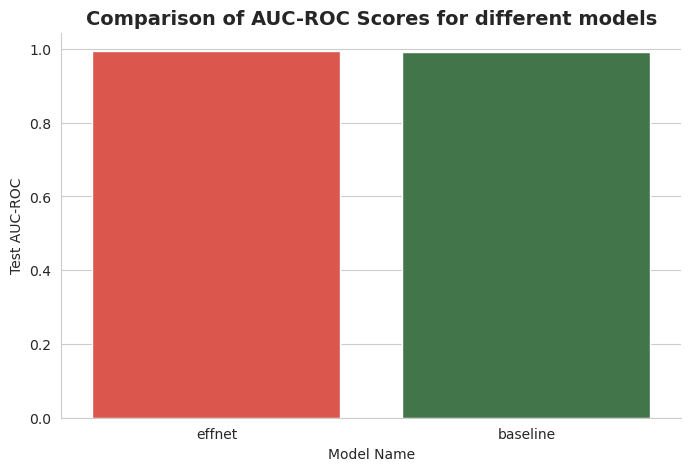

In [23]:
results = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
plt.title("Comparison of AUC-ROC Scores for different models", weight="bold", fontsize=14)
sns.barplot(x="model_name", y="test_aucroc", data=results, palette=[MY_COLORS[-1], MY_COLORS[0]])
plt.xlabel("Model Name")
plt.ylabel("Test AUC-ROC")
sns.despine()
plt.show()